In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from blimpy import Waterfall
from blimpy.utils import rebin
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm

MAX_PLT_POINTS      = 65536                  # Max number of points in matplotlib plot
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot

fil_path = "data/filterbanks/"
h5_path = "data/h5/"

test_fil = fil_path + "blc20_guppi_57991_48899_3C161_0007.gpuspec.0000.fil"

fri_obs = h5_path + "GBT_57532_09539_HIP56445_fine.h5"

plt_args = {
            'aspect':'auto',
            'origin':'lower',
            'rasterized':True,
            'interpolation':'nearest',
            'cmap':'viridis'
            }

In [2]:
def norm_test(arr):
    return stats.normaltest(arr.flatten())

In [3]:
def show_stamp(window, i):
    test_data = window[:, i:i+200]
    plt.figure()
    plt.imshow(test_data, **plt_args)
    
def show_stamp_f(freqs, data, f):
    ind = bisect_left(freqs, f)
    test_data = data[:, ind:ind+200]
    plt.figure()
    plt.imshow(test_data, **plt_args)
    
def plot_segment(plot_data):
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = int(plot_data.shape[0] / MAX_IMSHOW_POINTS[0])

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y = int(plot_data.shape[1] / MAX_IMSHOW_POINTS[1])

    print(f'Downsampling by a factor of ({dec_fac_x}, {dec_fac_y})')
    plot_data = rebin(plot_data, dec_fac_x, dec_fac_y)
    plt.figure(figsize=(10, 6))
    plt.imshow(plot_data, **plt_args)

In [42]:
# Show Info
wf = Waterfall(fri_obs, load_data=False)
wf.info()
wf.header

blimpy.file_wrapper INFO     Skipping loading data ...

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16,

{b'DIMENSION_LABELS': array([b'frequency', b'feed_id', b'time'], dtype=object),
 b'az_start': 0.0,
 b'data_type': 1,
 b'fch1': 1926.26953125,
 b'foff': -2.835503418452676e-06,
 b'machine_id': 20,
 b'nbits': 32,
 b'nchans': 318230528,
 b'nifs': 1,
 b'source_name': b'HIP56445',
 b'src_dej': <Angle 3.05944611 deg>,
 b'src_raj': <Angle 11.57269417 hourangle>,
 b'telescope_id': 6,
 b'tsamp': 17.986224128,
 b'tstart': 57532.11040509259,
 b'za_start': 0.0}

In [34]:
wf = Waterfall(fri_obs, f_stop=1080, max_load=2)
wf.info()

blimpy.file_wrapper WARNING  Setting data limit > 1GB, please handle with care!


/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/blimpy/file_wrapper.py:326: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(self.filename)



--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16, 1, 318230528)
--- Selection Info ---
Data selection sh

In [35]:
channel_len = np.int(np.round(187.5/64/abs(wf.header[b'foff'])))

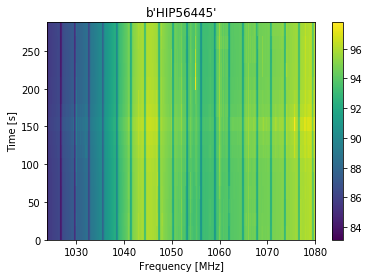

In [36]:
plt.figure()
wf.plot_waterfall(f_start=0, f_stop=1080)

In [37]:
freqs, data = wf.grab_data(f_start=0, f_stop=1080)
print(data.shape)
freqs = freqs[::-1]
data = data[:,::-1]

(16, 19775754)


In [41]:
len(freqs)/channel_len

19.139999767715558

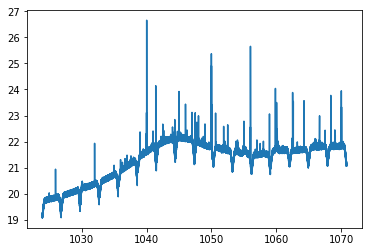

In [44]:
data = data[:, :16 * 1033216]
freqs = freqs[:16 * 1033216]

integrated = np.sum(data, axis=0)/len(data)
for n in np.nonzero(integrated > 10**13):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
plt.figure()
plt.plot(freqs, np.log(integrated))


Downsampling by a factor of (1, 252)


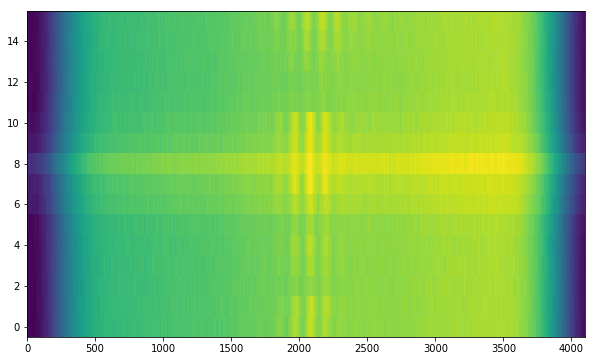

In [45]:
c = 6

window = data[:, channel_len*(c):channel_len*(c+1)]
plot_segment(np.log(window))

In [46]:
window

array([[1.8034956e+09, 1.7789466e+09, 1.6850761e+09, ..., 1.8884800e+09,
        1.7214487e+09, 1.3809622e+09],
       [1.7263657e+09, 1.7499603e+09, 1.7450801e+09, ..., 1.8666890e+09,
        2.0712874e+09, 1.7819872e+09],
       [1.7078250e+09, 2.0026440e+09, 1.9118678e+09, ..., 1.6442719e+09,
        1.5118506e+09, 1.6894335e+09],
       ...,
       [1.7899773e+09, 1.7129288e+09, 1.8505032e+09, ..., 1.9386944e+09,
        1.8534162e+09, 1.7500471e+09],
       [1.8657156e+09, 1.6503720e+09, 1.9404667e+09, ..., 1.7936076e+09,
        1.6499114e+09, 1.8753235e+09],
       [1.9375962e+09, 1.7814765e+09, 1.7064093e+09, ..., 1.9241290e+09,
        1.6184998e+09, 1.7303356e+09]], dtype=float32)

In [23]:
res = []
for chan in tqdm(range(15)):
    res.append([])
    window = data[:, channel_len*(chan):channel_len*(chan+1)]
    window_f = freqs[channel_len*(chan):channel_len*(chan+1)]
    for i in range(0, (len(window[0])//200*200), 100):
        test_data = window[:, i:i+200]
        s, p = norm_test(test_data)
        if p < 1e-25:
            res[chan].append((window_f[i], s, p))

  0%|          | 0/15 [00:00<?, ?it/s]/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/scipy/stats/stats.py:979: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/scipy/stats/stats.py:977: RuntimeWarning: overflow encountered in square
  s = s**2
 13%|█▎        | 2/15 [00:14<01:32,  7.13s/it]/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
100%|██████████| 15/15 [01:47<00:00,  7.08s/it]


In [52]:
from multiprocessing import Pool
from time import time

import warnings
warnings.filterwarnings("ignore")


def threshold_hits(chan):
    res = list()
    window = data[:, channel_len*(chan):channel_len*(chan+1)]
    window_f = freqs[channel_len*(chan):channel_len*(chan+1)]
    for i in range(0, (len(window[0])//200*200), 100):
        test_data = window[:, i:i+200]
        s, p = norm_test(test_data)
        if p < 1e-25:
            res.append((window_f[i], s, p))
    return res

start = time()
with Pool(12) as p:
    chan_hits = p.map(threshold_hits, range(16))
end = time()
print(end-start)

22.503838062286377


84

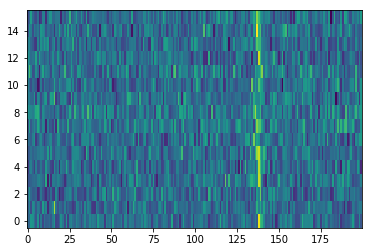

In [49]:
show_stamp_f(freqs, data, 1025.0100805927195)

In [50]:
hits = [len(e) for e in chan_hits]
print(hits)
print(sum(hits))

[12, 1616, 2179, 5, 16, 50, 272, 4254, 87, 109, 1450, 17, 404, 356, 658]
11485


In [ ]:
sorted_hits = sorted(res[7], key=lambda x: x[2])
sorted_hits

In [ ]:
top = [x[0] for x in sorted_hits[:20]]
top

In [ ]:
for i in top:
    print(i)
    show_stamp(window, i)

In [ ]:
res[:15]

In [ ]:
plt.figure()
plt.imshow(data[:, 8:8+128])

In [ ]:
with open("pfb512coef.txt", "r") as f:
    coef_file = f.read()

In [ ]:
lines = coef_file.splitlines()
filter_coefs = []
for line in lines:
    filter_coefs.append(float(line))

In [ ]:
coefs = np.array(filter_coefs)/2**17

In [ ]:
plt.figure()
plt.plot(coefs)

In [ ]:
from numpy import fft
l = 2**16
f = fft.fft(coefs, l)
plt.figure()
plt.plot(np.log(np.abs(f)**2))

In [ ]:
stacked = np.reshape(integrated, (15, 1033216))
plt.figure()
for i in range(15):
    plt.plot(np.log(stacked[i]))

In [ ]:
rebined = rebin(stacked, 1, 64)

In [ ]:
plt.figure()
plt.imshow(np.log(rebined), **plt_args)

In [ ]:
model_shape = np.sum(stacked, axis=0)/15
model_shape[model_shape > 10**10] = np.mean(model_shape)

In [ ]:
plt.figure()
plt.plot(model_shape)